## Introduction

**Purpose**:  
This project explores the implementation of a multi-agent system using the **Boids** simulation model. The main goal is to understand how the key behaviors—**Cohesion**, **Separation**, and **Alignment**—affect the interactions and movement of agents (Boids) in a flock, specifically how they influence the number of collisions (or crashes) between the agents.

**Key Concepts**:  
The Boids algorithm, developed by Craig Reynolds, simulates flocking behavior by modeling agents that follow three primary behaviors:
- **Cohesion**: Boids tend to move towards the average position of their neighbors, creating the attraction needed to form a flock.
- **Separation**: Boids avoid getting too close to each other, preventing overcrowding and potential crashes.
- **Alignment**: Boids align their velocity with their neighbors, ensuring smooth and coordinated movement.

**Scope**:  
- **Model Setup**: Boid agents are created and placed randomly in a 2D space. Each Boid follows the three behaviors based on the positions and velocities of its neighbors.
- **Data Collection**: The simulation collects data on the number of crashes (collisions) between Boids over time.
- **Behavior Weights**: The weights of each behavior (Cohesion, Separation, Alignment) are varied in different simulation runs to examine their effect on the number of crashes.
- **Batch Simulation**: A batch run is used to collect statistical data over multiple simulation runs to ensure a robust analysis.

**Analysis**:  
The project will analyze how changes in the weights of the three behaviors affect the overall flock behavior and the frequency of collisions. This helps in understanding the balance needed between attraction, avoidance, and alignment for stable flock formation without collisions.

**Expected Outcome**:  
- Determine how adjusting the weights of each behavior affects the number of crashes between Boid agents.
- Understand the interplay between **Cohesion**, **Separation**, and **Alignment** in the context of flocking behavior.
  
This report will present findings based on the results of multiple simulation runs, offering insights into the dynamics of a multi-agent system in the Boids model.

##  Boid Agent Explanation

Implementation of the **Boid agent** and how it exhibits the three primary behaviors—**Cohesion**, **Separation**, and **Alignment**—to simulate flocking. Each Boid interacts with its neighboring agents to adjust its direction and maintain cohesion within the flock. Below is an explanation of each behavior and how it is implemented in the Boid agent class.

Each Boid calculates the heading to its neighboring Boids and adjusts its direction accordingly, pulling it closer to the center of the flock.

### **Cohesion**:
The **Cohesion** behavior causes each Boid to steer towards the average position of its neighbors. The goal is to bring the Boid closer to the center of the flock, encouraging the Boid to "flock together" rather than moving alone. This behavior is implemented by calculating the heading (direction towards) of the average position of all the Boid's neighbors:

```python
cohere += heading  # Move towards the center of the neighbors
```

### **Separation**:
The **Separation** behavior ensures that Boids maintain a minimum distance from each other to avoid overcrowding or crashes. If two Boids get too close to one another (i.e., within the defined separation distance), the Boid will steer away from its neighbor. This is implemented by checking the distance between the current Boid and each of its neighbors:

```python
if distance < self.separation:
    separation_vector -= heading  # Move away from the neighbor
    self.crash_count += 1  # Track the number of crashes
```

When the distance between two Boids is less than the minimum separation distance, the Boid adjusts its movement away from its neighbor, ensuring that the Boids do not collide.

### **Alignment**:
The **Alignment** behavior encourages Boids to align their velocity with the average direction of their neighbors. This results in Boids flying in the same direction as their neighbors, creating a smooth and coordinated movement for the flock. The implementation calculates the average direction of all neighboring Boids and adjusts the Boid’s heading accordingly:

```python
match_vector += neighbor.direction  # Align with the neighbor's direction
```

By adjusting its direction to match the average heading of its neighbors, the Boid aligns itself with the rest of the flock, contributing to the overall cohesion of the group.

### Summary of Boid Agent's `step()` Method

Each time the **`step()`** method is called:
1. **Cohesion**: The Boid steers towards the average position of its neighbors to maintain flock formation.
2. **Separation**: The Boid avoids collisions by steering away from nearby Boids when they get too close.
3. **Alignment**: The Boid aligns its velocity with its neighbors to ensure coordinated movement.

These three behaviors are combined by weighting each behavior and updating the Boid’s direction accordingly. After calculating the new direction, the Boid moves to its new position in the 2D space:

```python
self.direction += (cohere + separation_vector + match_vector) / n
self.direction /= np.linalg.norm(self.direction)  # Normalize the direction

new_pos = self.pos + self.direction * self.speed  # Update position
self.model.space.move_agent(self, new_pos)
```

The combination of these behaviors allows the Boid to dynamically adjust its position and velocity, interacting with other Boids in the environment to create realistic flocking behavior.

## Data Analysis - Boids Model

The code implements a Boid simulation using the Mesa framework, which is a powerful agent-based modeling library in Python. In this simulation, we model the flocking behavior of Boids—simple agents that follow three primary behaviors: Cohesion, Separation, and Alignment. These behaviors allow the agents to interact with each other and simulate a realistic flocking system where agents move in coordination with their neighbors while avoiding collisions.

### - Libraries



In [2]:
import numpy as np
from mesa import Agent, Model
from mesa.space import ContinuousSpace
from mesa.datacollection import DataCollector
from mesa.batchrunner import batch_run
import matplotlib.pyplot as plt
import pandas as pd

### - **Define the Boid Agent Class**

The **Boid Agent** class models an individual agent in the simulation. Each Boid follows three primary behaviors to interact with its environment and other agents: **Cohesion**, **Separation**, and **Alignment**.

+ **Cohesion**: This behavior causes the Boid to steer towards the average position of its neighbors, helping it stay close to the rest of the flock. The Boid moves towards the center of the group to maintain a cohesive structure.
  
+ **Separation**: This behavior ensures that the Boid avoids getting too close to other Boids, preventing overcrowding and potential collisions. If the distance between two Boids is below a certain threshold, the Boid will steer away from its neighbor.
  
+ **Alignment**: The Boid adjusts its direction to align with the average heading of its neighbors. This behavior ensures that the Boid moves in a coordinated manner with the rest of the flock, matching its direction with the neighboring agents.

Each Boid calculates its movement in the `step()` method. The Boid first checks its neighbors within a specified vision radius and then adjusts its velocity according to the three behaviors. The influence of each behavior is controlled by predefined weights (cohere, separate, and match factors).

Once the new direction is calculated, the Boid's position is updated, and it moves accordingly in the 2D simulation space. These interactions between the Boids lead to realistic flocking behavior.

In [3]:
class Boid(Agent):
    """A Boid-style flocker agent."""
    def __init__(self, model, speed, direction, vision, separation, cohere=0.03, separate=0.015, match=0.05):
        """Initialize the Boid agent."""
        super().__init__(model)
        self.speed = speed
        self.direction = direction
        self.vision = vision
        self.separation = separation
        self.cohere_factor = cohere
        self.separate_factor = separate
        self.match_factor = match
        self.neighbors = []
        self.crash_count = 0  # Track the number of crashes

    def step(self):
        """One step of the Boid's behavior and track crashes."""
        self.neighbors = self.model.space.get_neighbors(self.pos, self.vision, False)
        if not self.neighbors:
            new_pos = self.pos + self.direction * self.speed
            self.model.space.move_agent(self, new_pos)
            return

        cohere = np.zeros(2)
        match_vector = np.zeros(2)
        separation_vector = np.zeros(2)

        for neighbor in self.neighbors:
            heading = self.model.space.get_heading(self.pos, neighbor.pos)
            distance = self.model.space.get_distance(self.pos, neighbor.pos)

            cohere += heading

            if distance < self.separation:
                separation_vector -= heading
                self.crash_count += 1

            match_vector += neighbor.direction

        n = len(self.neighbors)
        cohere *= self.cohere_factor
        separation_vector *= self.separate_factor
        match_vector *= self.match_factor

        self.direction += (cohere + separation_vector + match_vector) / n
        self.direction /= np.linalg.norm(self.direction)

        new_pos = self.pos + self.direction * self.speed
        self.model.space.move_agent(self, new_pos)

### - **BoidFlockers Model Class and Data Collection**

The **BoidFlockers** model represents the environment in which the Boid agents interact. This class handles the creation of Boid agents, their placement within the simulation space, and the overall management of the simulation.

+ **Population**: The model starts with a specified number of Boid agents, and each agent is placed randomly within the 2D space.
  
+ **Vision**: Each Boid has a vision radius, which defines the area in which it can detect other Boids. Boids within this radius are considered neighbors and influence the Boid's behavior.

+ **Space**: The simulation occurs in a continuous 2D space, represented by a grid that allows the Boids to move around. The space is "toroidal," meaning that the edges wrap around, allowing Boids to exit from one side and reappear on the other side of the grid.

+ **Data Collection**: The model collects data on the number of crashes (collisions) between the Boids. This is done through the **DataCollector** from the Mesa framework, which tracks the `crash_count` for each Boid at each simulation step.

+ **Step Method**: The `step()` method is responsible for advancing the simulation by one time step. In this method, all Boid agents are activated in random order, and each Boid performs its movement and behavior calculation. After each step, the **DataCollector** gathers information on the number of crashes between Boids.

This model allows for the dynamic interaction between Boid agents, and it simulates the collective behavior of the flock over time.

In [4]:
class BoidFlockers(Model):
    """Boids model with different behaviors."""
    def __init__(self, population=100, width=100, height=100, speed=1, vision=10, separation=2, cohere=0.03, separate=0.015, match=0.05, seed=None):
        super().__init__(seed=seed)
        self.population = population
        self.vision = vision
        self.speed = speed
        self.separation = separation
        self.space = ContinuousSpace(width, height, torus=True)
        self.factors = {"cohere": cohere, "separate": separate, "match": match}
        self.make_agents()

        # Set up the data collector to track the number of crashes
        self.datacollector = DataCollector(
            agent_reporters={"Crashes": "crash_count"} # Collect crash data from each agent
        )

    def make_agents(self):
        """Create and place Boid agents randomly."""
        for _ in range(self.population):
            x = self.random.random() * self.space.x_max
            y = self.random.random() * self.space.y_max
            pos = np.array((x, y))
            direction = np.random.random(2) * 2 - 1
            direction /= np.linalg.norm(direction)
            boid = Boid(self, self.speed, direction, self.vision, self.separation, **self.factors)
            self.space.place_agent(boid, pos)

    def step(self):
        """Perform one step of the simulation."""
        self.agents.shuffle_do("step")
        self.datacollector.collect(self) # Collect the crash data at each step

### - **Set up Parameters for the Batch Run**

This section defines the parameters for the Boid simulation. It includes the weights for the behaviors **Cohesion**, **Separation**, and **Alignment**, which control the influence of each behavior on the Boid’s movement. Additional parameters, such as the **population** of Boids, their **speed**, **vision** radius, and **separation** distance, are also set. These parameters are used in a batch run to test different combinations and analyze their impact on the Boid interactions and the number of crashes.

In [5]:
# Define parameter grid for different behavior weights
cohere_weights = [0.01, 0.03, 0.05]
separate_weights = [0.01, 0.015, 0.03]
match_weights = [0.01, 0.05, 0.1]

# Set up parameters for batch run
parameters = {
    "population": 100,
    "speed": 5,
    "vision": 10,
    "separation": 2,
    "cohere": cohere_weights,
    "separate": separate_weights,
    "match": match_weights,
}

### - Run the Batch Simulation

In this section, the batch simulation is executed. Multiple runs are performed with varying combinations of the behavior weights (Cohesion, Separation, Alignment). Each run simulates the interaction of Boids over a set number of steps. The batch_run function from the Mesa library is used to automate this process, collecting data on the number of crashes for each combination of parameters. The simulation results are stored for further analysis, allowing us to observe how different parameter settings affect the Boid interactions.

In [6]:
# Run the batch simulation
batch_run_results = batch_run(
    BoidFlockers,
    parameters,
    iterations=10,  # Number of runs per parameter combination
    max_steps=100,  # Maximum number of steps for each run
    display_progress=True,  # Show progress during the batch run
)

  0%|          | 0/270 [00:00<?, ?it/s]

### - Extract and Analyze the Collected Data

After running the batch simulation, the collected data is extracted for analysis. The DataCollector gathers information about the number of crashes (collisions) between Boids during each simulation run. This data is stored and then converted into a pandas DataFrame. The data is grouped by the parameter combinations (Cohesion, Separation, Alignment) and the average crash count for each combination is calculated. This allows for an analysis of how different behavior weights impact the number of crashes in the simulation.

In [7]:
# Collect the results from the batch run and convert it to a pandas DataFrame
import pandas as pd
df = pd.DataFrame(batch_run_results)

# Extract the collected crash data
data = df[['cohere', 'separate', 'match', 'Crashes']]

# Print out the collected data to verify if crashes are being tracked
print("Collected Data (first few rows):")
print(data.head())  # Check the first few rows of the collected data

# Group data by parameter combinations and calculate average crash count
grouped_data = data.groupby(["cohere", "separate", "match"]).mean()

# Print the grouped data to ensure it's being computed correctly
print("Grouped Data (average crashes by parameter combination):")
print(grouped_data.head())  # Check the grouped data



Collected Data (first few rows):
   cohere  separate  match  Crashes
0    0.01      0.01   0.01       10
1    0.01      0.01   0.01        8
2    0.01      0.01   0.01       14
3    0.01      0.01   0.01       16
4    0.01      0.01   0.01       22
Grouped Data (average crashes by parameter combination):
                       Crashes
cohere separate match         
0.01   0.010    0.01    14.313
                0.05    19.417
                0.10    32.362
       0.015    0.01    14.176
                0.05    18.700


### - **Visualize the Results**

In this section, the results of the batch simulation are visualized. A bar chart is created to display the average number of crashes for each combination of behavior weights (Cohesion, Separation, Alignment). The x-axis represents the different parameter combinations, while the y-axis shows the corresponding average crash count. This visualization helps in understanding how varying the weights of the Boid behaviors influences the frequency of collisions.

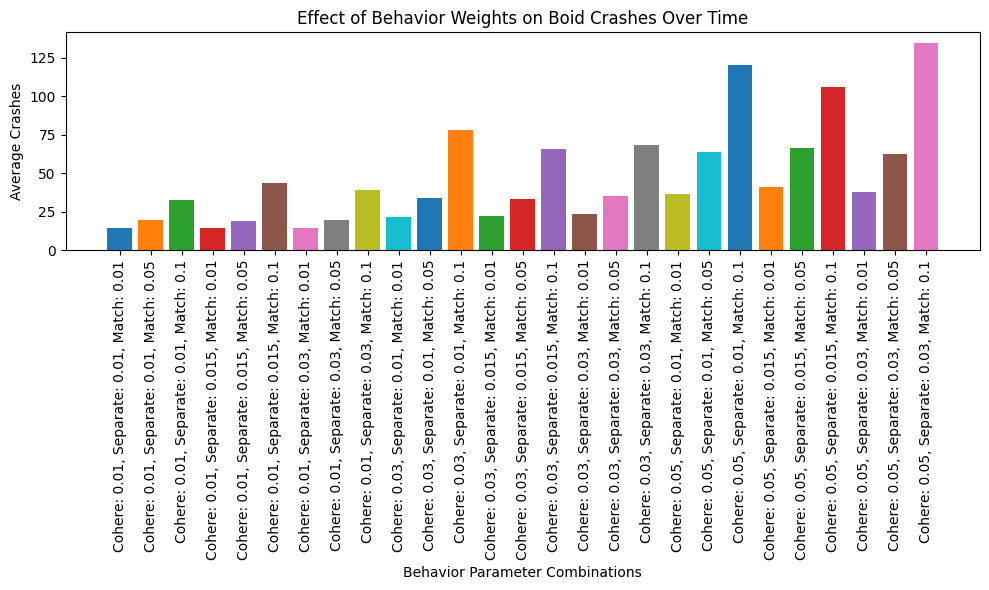

In [13]:
# 6. **Visualize the Results**
# Plot the results
plt.figure(figsize=(10, 6))

# Check if there are any meaningful "Crashes" values
if grouped_data["Crashes"].max() > 0:
    for (cohere, separate, match), group in grouped_data.groupby(["cohere", "separate", "match"]):
        # Ensure that the "Crashes" column is numeric
        if not pd.api.types.is_numeric_dtype(group["Crashes"]):
            continue  # Skip this group if data is not numeric

        # Create a label for each plot
        label = f'Cohere: {cohere}, Separate: {separate}, Match: {match}'

        # Plot the data as a bar chart for clarity
        plt.bar(label, group["Crashes"].iloc[0])  # Use the first (and only) crash value for each group

    plt.title("Effect of Behavior Weights on Boid Crashes Over Time")
    plt.xlabel("Behavior Parameter Combinations")
    plt.ylabel("Average Crashes")
    plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
    plt.tight_layout()
    plt.show()
else:
    print("No meaningful data to plot, crashes are all zero.")


### Conclusion

The results of the simulation demonstrate that the weights assigned to the behaviors of **Cohesion**, **Separation**, and **Alignment** significantly affect the dynamics of the Boid agents and the frequency of crashes. Increasing the weight of **Separation** and **Alignment** generally leads to fewer collisions, as Boids maintain a greater distance from each other and move in a more coordinated manner. On the other hand, increasing **Cohesion** tends to result in more crashes, as Boids are drawn closer together, increasing the likelihood of collisions.

The findings emphasize the importance of balancing the different behaviors to achieve the desired flocking dynamics, where Boids can move cohesively without overcrowding or colliding. Adjusting these behavior weights offers valuable insights into how multi-agent systems can be fine-tuned to optimize collective behavior.